In [1]:
import os
import pandas as pd
from sklearn.model_selection import ShuffleSplit
import numpy as np
import torch
import random

from dataset import parse_dataset, RSNADataset, get_dicom_fps
from myUtils import visualize_random_image, make_validation, get_model, get_test_predictions, get_sub_list, write_submission

In [ ]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(99)

## Загрузим датасет

Данные скачивались с https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data . Для дальнейшей работы укажите в переменной data_path локальный путь к данным.

In [2]:
data_path = "/mnt/ubuntu_hdd/rsna"
train_img_path = os.path.join(data_path, "stage_2_train_images")
annotations = pd.read_csv(os.path.join(data_path, "stage_2_train_labels.csv"))

image_fps, image_annotations = parse_dataset(train_img_path, anns=annotations)

## Посмотрим на случайное изображение больного пациента

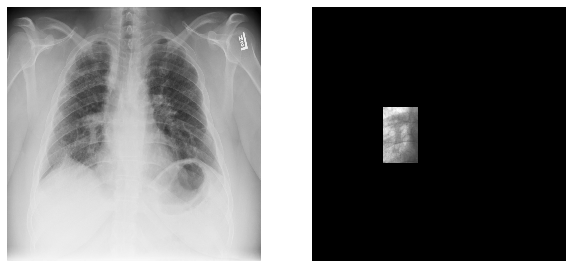

In [3]:
img_size = 1024
dataset = RSNADataset(image_fps[:2000], image_annotations, img_size, img_size, train=True)
visualize_random_image(dataset)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2
img_size = 1024
print("your device: {}".format(device))

your device: cuda


## Обучение

In [ ]:
# Для аккуратной валидации используйте больше разбиений
n_splits = 1
cv = list(ShuffleSplit(n_splits=n_splits, random_state=15, test_size=0.2).split(np.zeros((len(image_fps), 1)),
                                                                   np.zeros(len(image_fps))))

params = {"img_size": img_size, "num_classes": num_classes, "num_epochs": 1, "device": device}

images_files = np.array(image_fps)

make_validation(images_files=images_files, image_annotations=image_annotations, cv=cv, params=params)

## Test

In [8]:
model = get_model(num_classes=num_classes)
model.load_state_dict(torch.load("epoch10"))
model.to(device)

test_images = get_dicom_fps(os.path.join(data_path, "stage_2_test_images"))

imgs_info = get_test_predictions(model, test_images, device, img_size)

# min_conf -- минимальный порог уверенности для того, чтобы считать объект пневмонией
sub_list = get_sub_list(imgs_info, img_size, min_conf=0.7)

write_submission(sub_list)